<span style="font-size: 14pt">EREVAN, May-June 2017</span>

<span style="font-size: 16pt"> Practice day #2: ES models

<span style="color:blue; font-size: 12pt">Alexey Romanenko </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>

<h1 align="center">Info</h1> 

This practice task is desinged for impriving knowledge of ARIMA models and getting aqcuainted with statistical time series analysis in python.

The task should take about 3-5 hours to be completed.

<h1 align="center">1. Reading data (5%)</h1>

  * Download data for following data sets
     - 1) <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">monthly-wage.csv </span>(1 TS of monthly wage in Russia)
     - 2) <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">energy_cunsumption.csv</span> (105 TS of goods sales in shop #36 of one real Retail Net, each TS correspond to an item in shop )
 
 All data you can find by <a href='https://1drv.ms/f/s!AqGgzb5T4tvShZ5by4qa_HFqAAoYIg'>link</a> 
 
 
 * For each data set: 
      - 1) learn it's structure in csv-file and read it into Pandas data frame (be careful with parsing data)
      - 2) plot each time series
      - 3) answer the questions: is there seasonlaity, trend, changes in level in TS? If there is seasonality then define period of seasonality. 

In [1]:
import numpy as np
from datetime import datetime, timedelta
import pylab
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import math
import pandas.tseries.offsets as ofs
from scipy import stats
import statsmodels.api as sm
import time
import warnings as w
import plotly.plotly as py
from IPython.display import Image

%matplotlib inline

/home/daniel/.local/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


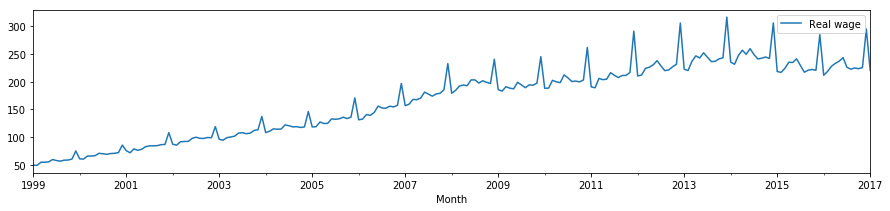

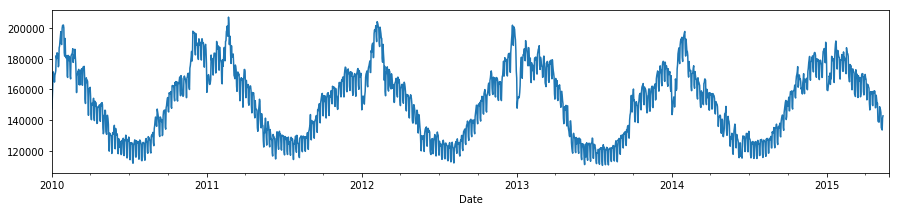

In [15]:
ts = pd.read_csv('monthly_wage.csv', sep=';', decimal='.', index_col='Month', parse_dates=True, dayfirst=True)['1999-01-01':]
ts1 = pd.read_csv('energy_consump.csv', sep=',', decimal='.', index_col='Date', parse_dates=True, dayfirst=True)

ts.plot(figsize=(15,3))
plt.show()
ts1['EnergyConsump'].plot(figsize=(15,3))
plt.show()

# REPORT
1. For monthly_wage.csv there are seasonality and trend. Changes in level almost absent (only between beginning and last part of data). The period is a year

2. For energy_consump.csv there is double seasonality. The periods are a year and a week. (In SARIMAX week-periodicity is more usefull)

<h1 align="center">2. ARIMA Momdel for wage dataset (40%) </h1>
You need to analyseTS <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">monthly-wage.csv</span> in accordance with forecasting scheme (see lecture slide Scheme of TS forecasting with ARIMA) and then build forecast.

<br />
<h1 align="center">2.I</h1>
**I. Select ARIMA parameters your self ** 
Also you can follow the next scheme:
<img src='./pic/ARMA Scheme.png'>


Notes: you need follow to the steps
 * 0) Use data before 01.02.2015 
 * 1) Plot the graph of time series, preprocess data (delete tail, make calendar transformation if needed)
 * 2) Dispersion is stabilized through transformation if needed.
 * 3) If the time series is non-stationary the differentiation degrees is
hosen.
 * 4) ACF/PACF are analyzed in order to understand whether AR(p)/MA(q) and seasonal $AR(P)/MA(Q)$  may be used.
 * 5) Candidate models are trained, their AIC/AIC is compared, choose trhe best model.
 * 6) Unbiasedness, stationarity and non-autocorrelation of the residuals of the obtained model are tested; if the tests fail model modifcations are reviewed.
 * 7) Build forecasts and forecastis interval for period from 01.02.2015 to 01.01.2017
     Calculate loss MACAPE of your Forecast.
     Does the forecast look like appropriate?

## 2.1.0 and 2.1.1

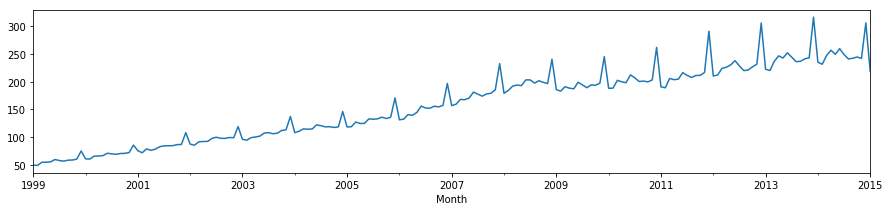

In [3]:
ts_trim=ts[:'2015-01-01']
ts_trim = ts_trim[ts_trim.columns[0]].dropna()
ts_trim.plot(figsize=(15,3))

## 2.1.3 differensing

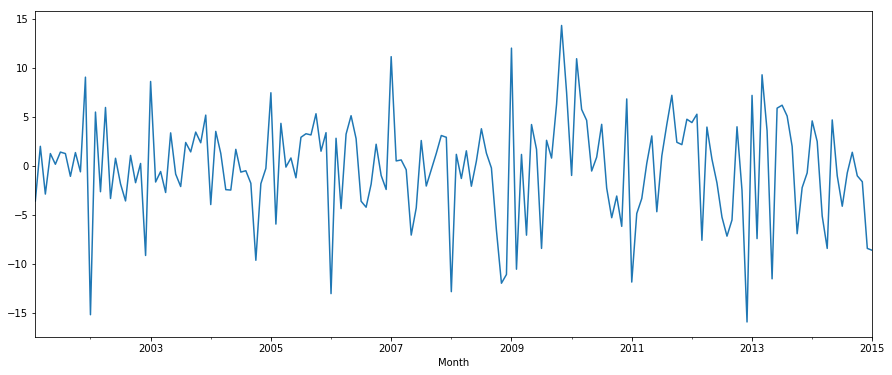

In [4]:
diff_ts = (ts_trim  - ts_trim.shift(12))[12:] #Seasonal derivative
diff_ts = (diff_ts  - diff_ts.shift(12))[12:] #Seasonal derivative

diff_ts = (diff_ts  - diff_ts.shift(1))[1:] #Simple derivative

diff_ts.plot(figsize=(15,6))

## 2.1.4 ACA/PACA

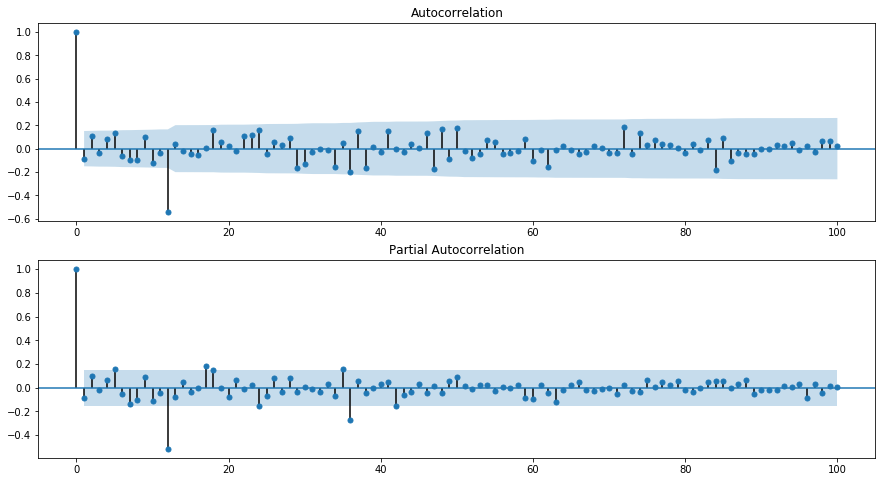

In [5]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff_ts.values.squeeze(), lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff_ts.values.squeeze(), lags=100, ax=ax2)

## 2.1.5

In [6]:
p=1 # y[t]=f(y[t-1], ..., y[t-p])+...   dependence of value history
d=0 # Range of simple derivative
q=1 # y[t]=f(e[t-1], ..., e[t-q])+...   dependence of error history

s=12 # Period of seasonality

P=3 # y[t]=f(y[t-s], ..., y[t-P*s])+...   seasonal dependence of value history
D=0 # Range of seasonal derivative y[t]-y[t-s]
Q=1 # y[t]=f(e[t-s], ..., e[t-Q*s])+...   seasonal dependence of error history

mod = sm.tsa.statespace.SARIMAX(diff_ts, trend='c', order=(p,d,q), seasonal_order=(P,D,Q,s)).fit()
mod.aic

925.13017712484157

## 2.1.6 Diagnostics

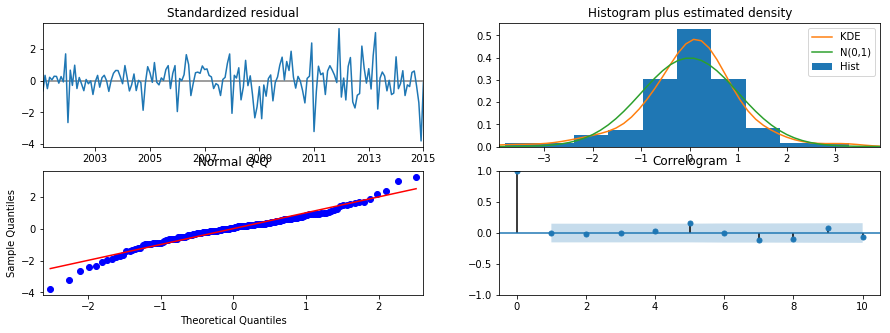

In [222]:
mod.plot_diagnostics(figsize=(15, 5))
plt.show()

## 2.1.7 Forecast for 2015-12-01 - 2017-01-01

In [6]:
myfit=sm.tsa.statespace.SARIMAX(ts[:'2015-02-01'], order=(1,1,1), seasonal_order=(3,1,1,12)).fit()

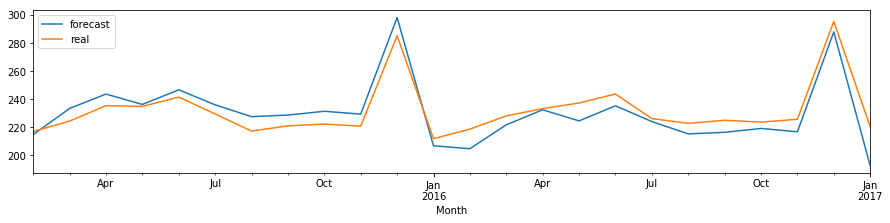

In [10]:
pred=myfit.predict(start='2015-02-01', end='2017-01-01')
pred.plot(figsize=(15,3), label='forecast')
ts["Real wage"]['2015-02-01':].plot(label='real')
plt.legend()

In [11]:
def qualityMACAPE(x,y):
    qlt = (2*(x-y).abs()/(x+y)).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , (x-y).abs()

print("MACAPE Accuracy:")
print(1-qualityMACAPE(pred,ts['Real wage']['2015-02-01':])[0])

MACAPE Accuracy:
0.964211952077


##### The forecast looks very appropriate

<br /><br /><br />
<h1 align="center">2.II</h1>
**II. Find the best parameters of ARIMA automaticaly** 
* 0) Use data before 01.02.2015 
* 1) Plot the graph of time series, preprocess data (delete tail, make calendar transformation if needed)
* 2) Run grid search for ARIMA parameters (at least for 3 distinct values for $p,q,d, P, Q, D$). 
How many time does it take?
* 4) Find the best set of parameters according to AIC.
* 5) Build the forecast of the best model and it's forecasting interval for period from 01.02.2015 to 01.01.2017.
* 6) Calculate locc MACAPE of your forecast.

## 2.2.2 Grid search

In [29]:
start=time.time()
def grid_search(p,d,q,P,D,Q,s):
    grid=np.array(np.meshgrid(p,d,q,P,D,Q))
    params=grid.reshape(6,grid.size/6).T
    
    score=[]
    i=0
    for k in params:
        i+=1
        try:
            mod = sm.tsa.statespace.SARIMAX(ts[:'2015-01-01'], trend='n', order=(k[:3]), seasonal_order=(k[3],k[4],k[5],s)).fit()
            score.append(mod.aic)
        except Exception:
            print("Can not fit model p,d,q,P,D,Q={} at step {}!".format(k,i))
       
    print("\nBest p,d,q,P,D,Q = "+str(params[np.argmin(np.array(score))])+"; AIC: "+str(min(score)))

grid_search([0,1],[0,1],[0,1],[0,1],[0,1],[0,1],12)
print("\nThe time of grid search is: "+str((time.time()-start)/60.0)+" min")

Can not fit model p,d,q,P,D,Q=[0 0 0 0 0 0] at step 1!
Can not fit model p,d,q,P,D,Q=[0 0 0 0 0 1] at step 2!
Can not fit model p,d,q,P,D,Q=[0 0 0 0 1 0] at step 3!
Can not fit model p,d,q,P,D,Q=[0 0 0 1 0 0] at step 5!
Can not fit model p,d,q,P,D,Q=[0 0 0 1 0 1] at step 6!
Can not fit model p,d,q,P,D,Q=[0 0 1 0 0 1] at step 10!
Can not fit model p,d,q,P,D,Q=[0 0 1 1 0 0] at step 13!
Can not fit model p,d,q,P,D,Q=[0 0 1 1 0 1] at step 14!
Can not fit model p,d,q,P,D,Q=[1 0 0 0 0 1] at step 18!
Can not fit model p,d,q,P,D,Q=[1 0 0 1 0 0] at step 21!
Can not fit model p,d,q,P,D,Q=[1 0 0 1 0 1] at step 22!
Can not fit model p,d,q,P,D,Q=[1 0 1 0 0 0] at step 25!
Can not fit model p,d,q,P,D,Q=[1 0 1 0 0 1] at step 26!
Can not fit model p,d,q,P,D,Q=[1 0 1 1 0 0] at step 29!
Can not fit model p,d,q,P,D,Q=[1 0 1 1 0 1] at step 30!
Can not fit model p,d,q,P,D,Q=[0 1 0 0 0 0] at step 33!
Can not fit model p,d,q,P,D,Q=[0 1 0 0 0 1] at step 34!
Can not fit model p,d,q,P,D,Q=[0 1 0 0 1 0] at step 3

<br /><br /><br />
<h1 align="center">3. ARIMA Momdel for wage dataset (55%) </h1>
You need to analyseTS <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">energy_consumption.csv</span> in accordance with forecasting scheme (see lecture slide Scheme of TS forecasting with ARIMA) and then build forecast.

**I. Select ARIMA parameters yourself **
Follow to the steps from 2.I. 

**II. Find the best parameters of ARIMA automaticaly**

In the previous task I showed that my grid-search works. In the future I will not use it and choose parameters according to ACF/PACF

** III. Adding of exogenious variables**

* 1) Try to add in models from 3.I. and 3.II exogenious variables (at least one of Temp1, Temp2, Saturday and Sunday).
* 2) Does it make accuracy of foreacast for period from 01.02.2015 to 01.01.2017 better?

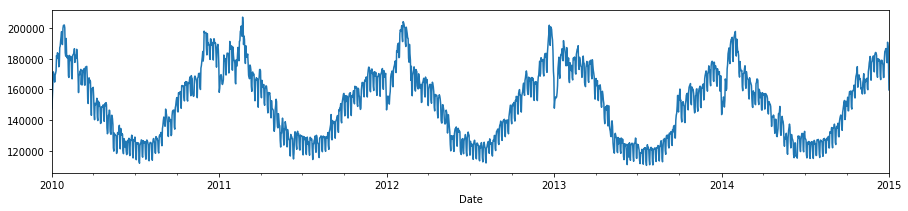

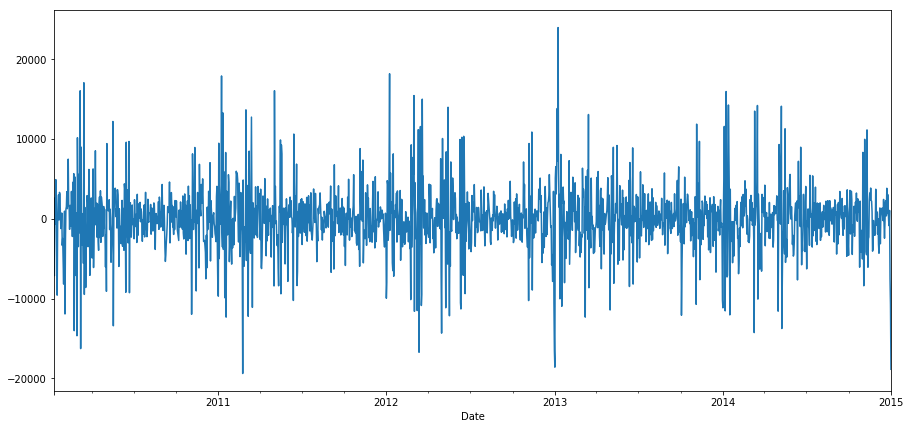

In [13]:
ts1=ts1[:"2015-01-01"]
ts1['EnergyConsump'].plot(figsize=(15,3))
plt.show()
diff = ts1['EnergyConsump']

diff = (diff - diff.shift(7))[7:]

diff = (diff - diff.shift(1))[1:]

diff.plot(figsize=(15,7))
plt.show()

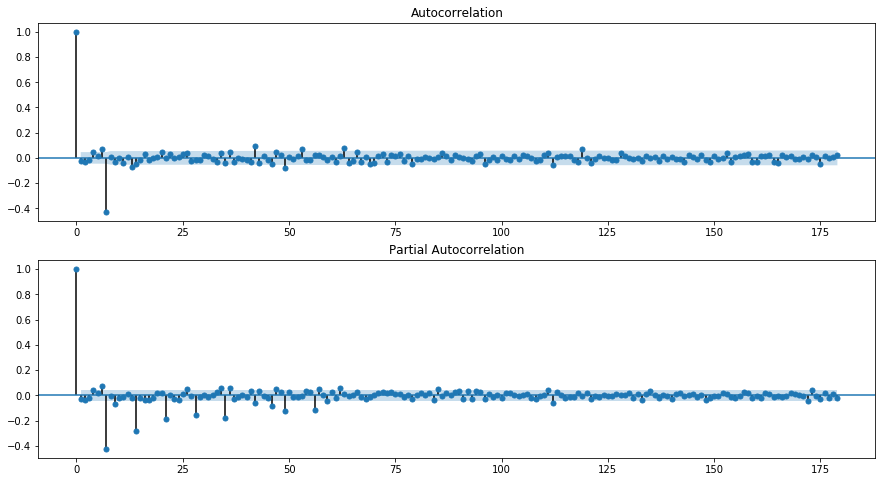

In [297]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff.values.squeeze(), lags=179, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff.values.squeeze(), lags=179, ax=ax2)

In [33]:
p=1 # y[t]=f(y[t-1], ..., y[t-p])+...   dependence of value history
d=0 # Range of simple derivative
q=1 # y[t]=f(e[t-1], ..., e[t-q])+...   dependence of error history

s=7 # Period of seasonality

P=9 # y[t]=f(y[t-s], ..., y[t-P*s])+...   seasonal dependence of value history
D=0 # Range of seasonal derivative y[t]-y[t-s]
Q=1 # y[t]=f(e[t-s], ..., e[t-Q*s])+...   seasonal dependence of error history

mod = sm.tsa.statespace.SARIMAX(diff, trend='n', order=(p,d,q), seasonal_order=(P,D,Q,s)).fit()
mod.aic

/home/daniel/.local/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



34639.776339743941

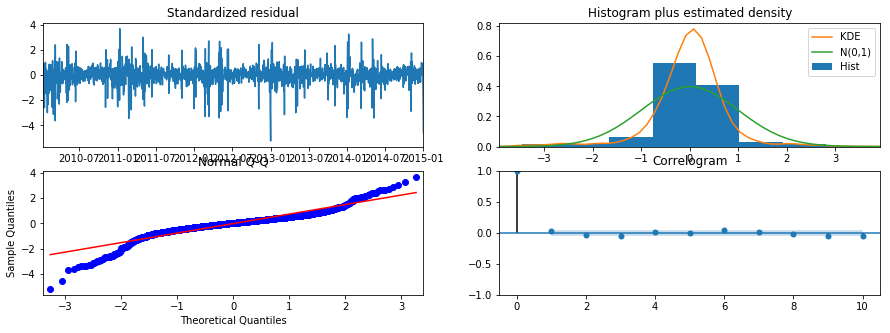

In [34]:
mod.plot_diagnostics(figsize=(15, 5))
plt.show()

<br /><br />
# I will fit data for :2015-01-01, and forecast for 2015-01-01:
## Without exogenous variables

In [14]:
p=1 # y[t]=f(y[t-1], ..., y[t-p])+...   dependence of value history
d=1 # Range of simple derivative
q=1 # y[t]=f(e[t-1], ..., e[t-q])+...   dependence of error history

s=7 # Period of seasonality

P=9 # y[t]=f(y[t-s], ..., y[t-P*s])+...   seasonal dependence of value history
D=1 # Range of seasonal derivative y[t]-y[t-s]
Q=1 # y[t]=f(e[t-s], ..., e[t-Q*s])+...   seasonal dependence of error history

mod = sm.tsa.statespace.SARIMAX(ts1['EnergyConsump'], trend='n', order=(p,d,q), seasonal_order=(P,D,Q,s)).fit()
mod.aic

34860.014564429192

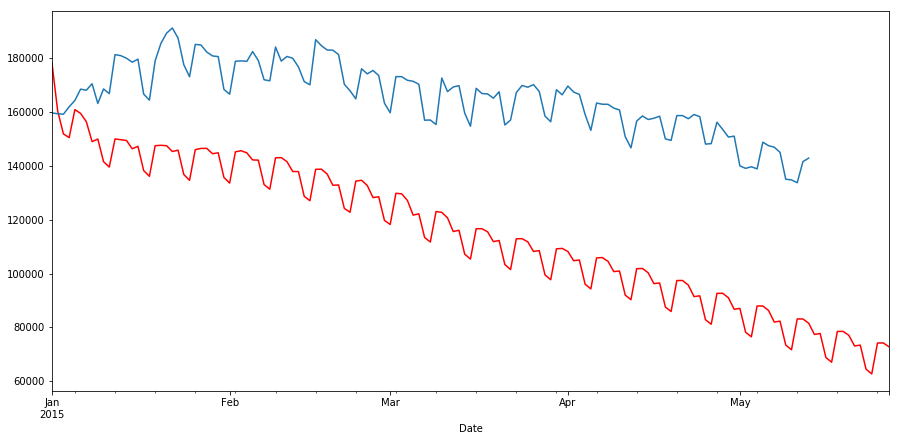

In [16]:
pred=mod.predict(start='2015-01-01', end='2015-05-27')
pred.plot(figsize=(15,7), color="r")
ts1['EnergyConsump']['2015-01-01':'2015-05-27'].plot()

In [17]:
print("Accuracy: "+str(1-qualityMACAPE(pred,ts1['EnergyConsump']["2015-01-01":])[0]))

Accuracy: 0.656418892678


<br /><br />
## With exogenous variables

In [19]:
exogs = ts1[['Temp1', 'Temp2', 'Saturday','Sunday']]

p=1 # y[t]=f(y[t-1], ..., y[t-p])+...   dependence of value history
d=1 # Range of simple derivative
q=2 # y[t]=f(e[t-1], ..., e[t-q])+...   dependence of error history

s=7 # Period of seasonality

P=9 # y[t]=f(y[t-s], ..., y[t-P*s])+...   seasonal dependence of value history
D=1 # Range of seasonal derivative y[t]-y[t-s]
Q=2 # y[t]=f(e[t-s], ..., e[t-Q*s])+...   seasonal dependence of error history

mod = sm.tsa.statespace.SARIMAX(ts1['EnergyConsump'][:"2015-01-01"], exog=exogs[:"2015-01-01"], order=(p,d,q), seasonal_order=(P,D,Q,s)).fit()
mod.aic


/home/daniel/.local/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



33717.772604250145

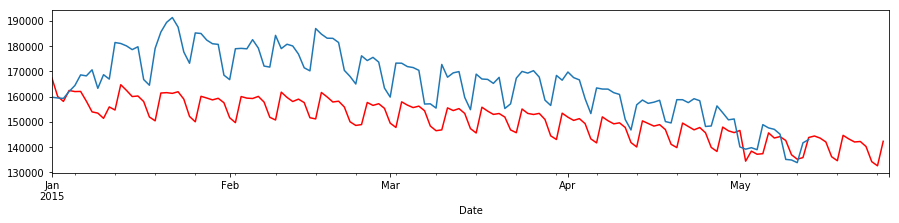

In [30]:
pred=mod.predict(start="2015-01-01", end="2015-05-26", exog=exogs["2015-01-01":"2015-05-25"])
pred.plot(figsize=(15,3), color="r")
ts1['EnergyConsump']["2015-01-01":].plot()

In [32]:
print('Accuracy')
print(1-qualityMACAPE(pred,ts1['EnergyConsump']["2015-01-01":])[0])


Accuracy
0.912634362976


##### Yes, accuracy is much more better